In [1]:
import numpy as np
import sklearn.datasets
import umap
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from sklearn.preprocessing import normalize

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


In [2]:
digits = sklearn.datasets.load_digits()
mnist = sklearn.datasets.fetch_openml("mnist_784")

In [3]:
mapper = umap.UMAP(n_neighbors=15).fit(mnist.data)

In [4]:
graph = mapper.graph_.copy()

In [5]:
graph.diagonal()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [6]:
def laplacian_from_graph(graph):
    laplacian = -graph
    laplacian.setdiag(np.zeros(graph.shape[0]))
    laplacian.setdiag(-np.squeeze(np.asarray(laplacian.sum(axis=1))))
    return laplacian

In [7]:
%%time
Q = laplacian_from_graph(graph)

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 875 ms, sys: 16 ms, total: 891 ms
Wall time: 892 ms


In [8]:
Q

<70000x70000 sparse matrix of type '<class 'numpy.float32'>'
	with 1521116 stored elements in Compressed Sparse Row format>

In [9]:
%%time
row, col = graph.nonzero()
B = scipy.sparse.lil_matrix((row.shape[0] // 2, graph.shape[0]))
k = 0
for n in range(row.shape[0]):
    i, j = row[n], col[n]
    if i < j:
        B[k, i] = 1
        B[k, j] = -1
        k += 1

CPU times: user 5.48 s, sys: 56 ms, total: 5.54 s
Wall time: 5.54 s


In [10]:
B

<725558x70000 sparse matrix of type '<class 'numpy.float64'>'
	with 1451116 stored elements in List of Lists format>

In [11]:
%%time
U = normalize(np.random.choice([-1, 1], size=(64, B.shape[0])), axis=0)

CPU times: user 504 ms, sys: 280 ms, total: 784 ms
Wall time: 782 ms


In [12]:
%%time
UB = (U @ B)

CPU times: user 627 ms, sys: 147 ms, total: 774 ms
Wall time: 771 ms


In [13]:
%%time
Z = np.vstack([scipy.sparse.linalg.lsqr(Q, UB[i])[0] for i in range(UB.shape[0])])

CPU times: user 33min 22s, sys: 1min 32s, total: 34min 55s
Wall time: 8min 43s


In [14]:
%%time
omega_est = np.zeros(row.shape[0])
for n in range(row.shape[0]):
    i, j = row[n], col[n]
    omega_est[n] = np.linalg.norm(Z[:, i] - Z[:, j])

CPU times: user 9.74 s, sys: 36 ms, total: 9.78 s
Wall time: 9.23 s


In [15]:
omega_est

array([1.4921117 , 1.32621727, 1.26327516, ..., 1.149994  , 1.18498434,
       1.06254587])

In [16]:
def compute_omega_est(graph):
    laplacian = laplacian_from_graph(graph)
    row, col = graph.nonzero()
    B = scipy.sparse.lil_matrix((row.shape[0] // 2, graph.shape[0]))
    k = 0
    for n in range(row.shape[0]):
        i, j = row[n], col[n]
        if i < j:
            B[k, i] = 1
            B[k, j] = -1
            k += 1
            
    U = normalize(np.random.choice([-1, 1], size=(64, B.shape[0])), axis=0)
    UB = (U @ B)
    Z = np.vstack([scipy.sparse.linalg.lsqr(Q, UB[i])[0] for i in range(UB.shape[0])])
    omega_est = np.zeros(row.shape[0])
    for n in range(row.shape[0]):
        i, j = row[n], col[n]
        omega_est[n] = np.linalg.norm(Z[:, i] - Z[:, j])
        
    coo_graph = graph.tocoo()
    omega_graph = coo_graph.copy()
    omega_graph.data = omega_est
    return omega_est, coo_graph, omega_graph.tocsr()

In [17]:
def compute_omega(graph):
    laplacian = laplacian_from_graph(graph)
    laplacian_pinv = np.linalg.pinv(laplacian.toarray())
    omega = np.zeros(graph.data.shape[0])
    coo_graph = graph.tocoo()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        omega[n] = laplacian_pinv[i, i] + laplacian_pinv[j, j] - laplacian_pinv[i, j] - laplacian_pinv[j, i]
            
    omega_graph = coo_graph.copy()
    omega_graph.data = omega
    return omega, coo_graph, omega_graph.tocsr()

/tmp/ipykernel_19636/1344073997.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(omega_est)


<AxesSubplot:ylabel='Density'>

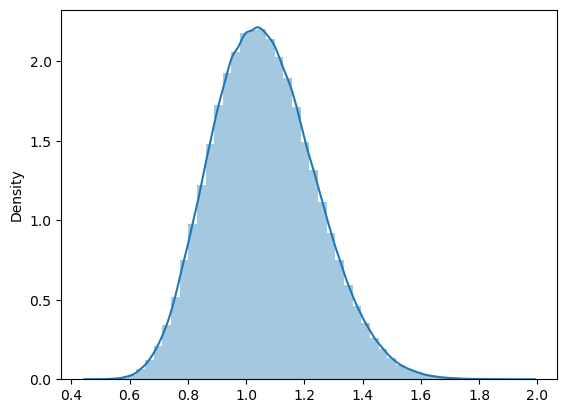

In [18]:
sns.distplot(omega_est)

In [20]:
def compute_resistance_link_curvature(graph):
    omega, coo_graph = compute_omega(graph)
    relative_resistance = graph.copy()
    relative_resistance.data *= omega
    resistance_curvature = 1 - 0.5 * np.squeeze(np.asarray(relative_resistance.sum(axis=1)))
    resistance_link_curvature = coo_graph.copy()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        if omega[n] > 0:
            resistance_link_curvature.data[n] = 2 * (resistance_curvature[i] + resistance_curvature[j]) / omega[n]
        else:
            resistance_link_curvature.data[n] = 0.0
        
    return resistance_link_curvature.tocsr()

In [21]:
def iterate_curvature_flow(graph, i):
    omega, next_graph, omega_graph = compute_omega_est(graph)
    print(omega, (omega_graph != omega_graph.transpose()).nnz)
    omega_scaling = (np.percentile(omega, 100 - 50 * np.power(2.0, -(i**2)/2)) - (omega))
#     omega_scaling /= omega_scaling.max()
    next_graph.data *= omega_scaling
#     next_graph -= 0.01 * omega_graph
#     next_graph.data /= omega
#     next_graph.data[omega_scaling < 0] = 0.0
#     next_graph = normalize(next_graph, norm="l1")
    next_graph.data[next_graph.data <0] = 0.0
    next_graph = normalize(next_graph, norm="l1")
    next_graph += next_graph.transpose()
    next_graph /= 2
#     next_graph = next_graph + next_graph.transpose() - next_graph.multiply(next_graph.transpose())
    next_graph.eliminate_zeros()
    return next_graph

In [22]:
%%time
for i in range(25):
    graph = iterate_curvature_flow(graph, i)

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[1.32807958 1.27742848 1.04195697 ... 0.87871007 1.22337692 1.09205344] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.75408862 0.83706568 0.68839455 ... 0.86962701 0.93235172 0.83984708] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.58662294 0.60186888 0.64410575 ... 0.50214061 0.40135312 0.50328243] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.58928579 0.55045732 0.60408288 ... 0.53222822 0.44516981 0.48593662] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.69376904 0.5503322  0.83699317 ... 0.57461416 0.45279351 0.46937806] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.59663326 0.58330271 0.38427141 ... 0.57433909 0.40830726 0.4669393 ] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.51031241 0.51354095 0.42637429 ... 0.62357879 0.41482191 0.52616776] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.61693393 0.51064763 0.43140445 ... 0.60848863 0.44756168 0.4877846 ] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.5060944  0.51601533 0.40121688 ... 0.58552634 0.45468813 0.49351935] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.64261745 0.53173588 0.4554458  ... 0.53870513 0.45475812 0.61341279] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.5507804  0.57038132 0.38309235 ... 0.49313605 0.41402901 0.42784536] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.57199011 0.43432261 0.44356453 ... 0.5807175  0.41272715 0.50938497] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.60124865 0.49344366 0.41976693 ... 0.65589814 0.46673363 0.51069857] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.5069915  0.55724209 0.43605019 ... 0.62259348 0.44452304 0.44414899] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.50739097 0.44965755 0.45855583 ... 0.52738341 0.38646788 0.49088955] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.62002465 0.54363068 0.41669555 ... 0.55315209 0.40482509 0.48087261] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.55290359 0.50962344 0.45178748 ... 0.56742456 0.44742117 0.48540761] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.61826161 0.54799457 0.40453698 ... 0.54642235 0.36354846 0.48297347] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.59743321 0.49972978 0.47058896 ... 0.53065857 0.4411298  0.52674272] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.54059224 0.4847092  0.4447275  ... 0.61609377 0.42943119 0.49005108] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.5490623  0.54788018 0.41256238 ... 0.64664708 0.45394315 0.51187982] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.66576935 0.50140147 0.42112328 ... 0.59151099 0.41716128 0.46325016] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.59770896 0.55850131 0.51485985 ... 0.51285528 0.43514299 0.45519676] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.53021626 0.52518547 0.4578391  ... 0.5287096  0.42308597 0.49239824] 0


/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.46867269 0.53357524 0.38639777 ... 0.61787994 0.46751933 0.5611156 ] 0
CPU times: user 12h 54min 13s, sys: 35min 26s, total: 13h 29min 39s
Wall time: 3h 24min 4s


In [23]:
graph

<70000x70000 sparse matrix of type '<class 'numpy.float32'>'
	with 400476 stored elements in Compressed Sparse Row format>

In [24]:
mapper.graph_

<70000x70000 sparse matrix of type '<class 'numpy.float32'>'
	with 1451116 stored elements in Compressed Sparse Row format>

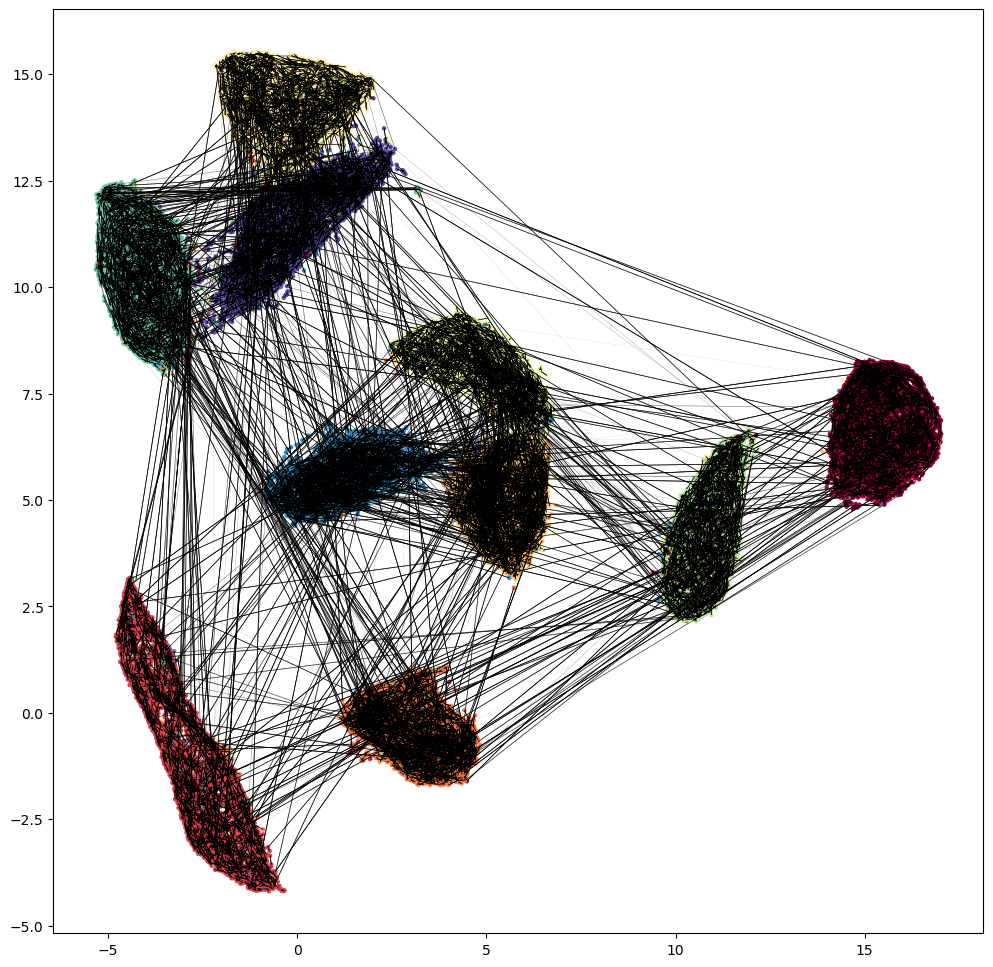

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = graph.tocoo()
edges = LineCollection(
    np.dstack([mapper.embedding_[coo_umap_graph.row], mapper.embedding_[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=np.clip(1e0 * coo_umap_graph.data, 0, 0.5),
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), np.clip(1e0 * coo_umap_graph.data, 0, 1)]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*mapper.embedding_.T, s=5, c=mnist.target.astype(np.int32), cmap="Spectral", zorder=0)

In [26]:
coo_umap_graph.data

array([1.9110970e-05, 8.6545432e-01, 9.7077477e-01, ..., 1.5310562e-09,
       7.6871848e-01, 5.9804800e-03], dtype=float32)

In [27]:
np.bincount(scipy.sparse.csgraph.connected_components(graph)[1])

array([65573,     1,     1, ...,     1,     1,     1])

In [28]:
import sklearn.metrics

In [29]:
sklearn.metrics.adjusted_rand_score(mnist.target, scipy.sparse.csgraph.connected_components(graph)[1])

0.00015426866751187552

In [30]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target, scipy.sparse.csgraph.connected_components(graph)[1])

0.0025858666169063763

In [31]:
import igraph as ig
import leidenalg

In [32]:
ig_graph = ig.Graph.Weighted_Adjacency(graph)

In [33]:
leiden_parts = list(leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition))
leiden_labels = np.full(graph.shape[0], -1, dtype=np.int32)
l = 0
for part in leiden_parts:
    if len(part) > 5:
        leiden_labels[part] = l
        l += 1

In [34]:
sklearn.metrics.adjusted_rand_score(mnist.target, leiden_labels)

0.5371202154781617

In [35]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target, leiden_labels)

0.7290040461777241

In [36]:
leiden_labels.max()

25

In [37]:
ig_orig_graph = ig.Graph.Weighted_Adjacency(mapper.graph_)

In [38]:
leiden_parts = list(leidenalg.find_partition(ig_orig_graph, leidenalg.ModularityVertexPartition))
leiden_labels = np.full(graph.shape[0], -1, dtype=np.int32)
l = 0
for part in leiden_parts:
    if len(part) > 5:
        leiden_labels[part] = l
        l += 1

In [39]:
sklearn.metrics.adjusted_rand_score(mnist.target, leiden_labels)

0.7809437156326698

In [40]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target, leiden_labels)

0.8434349869014903

In [41]:
import hdbscan

In [42]:
hdb_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(mapper.embedding_)

In [43]:
sklearn.metrics.adjusted_rand_score(mnist.target, hdb_labels)

0.8431938722130187

In [44]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target, hdb_labels)

0.8907118064890617

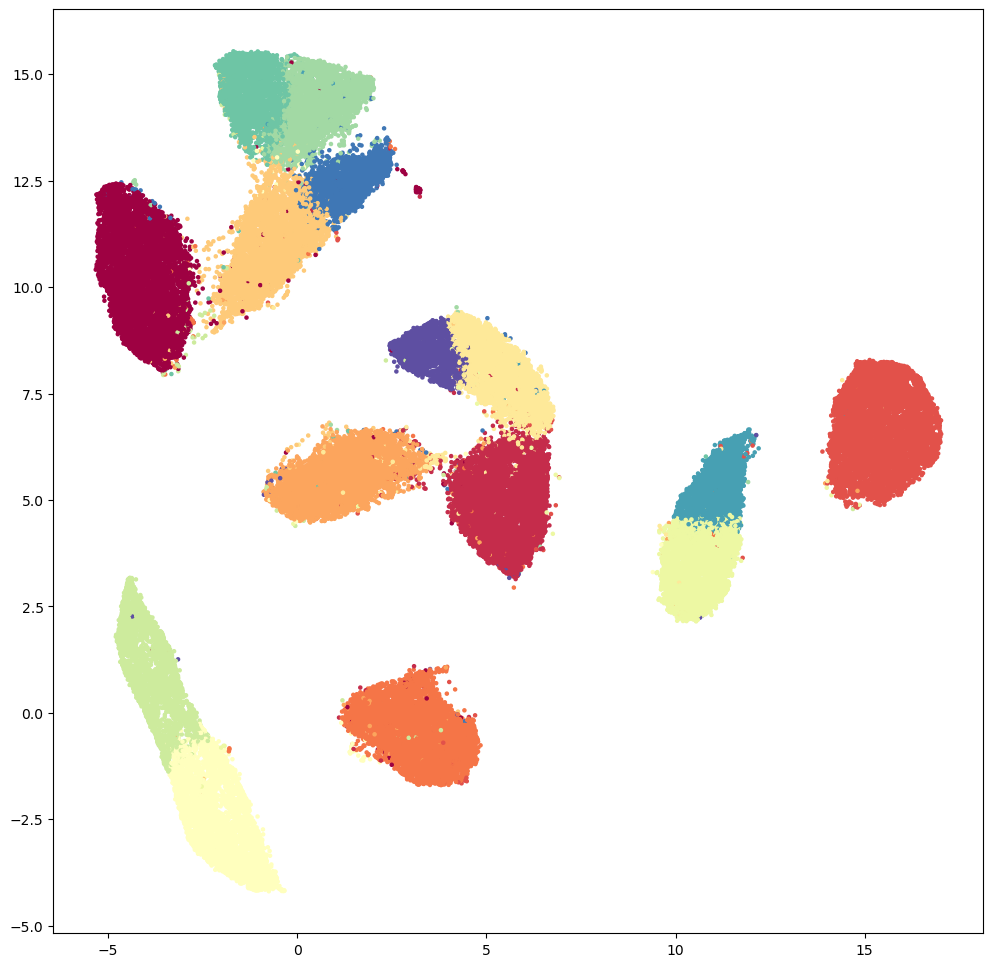

In [45]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*mapper.embedding_.T, s=5, c=leiden_labels, cmap="Spectral", zorder=0)

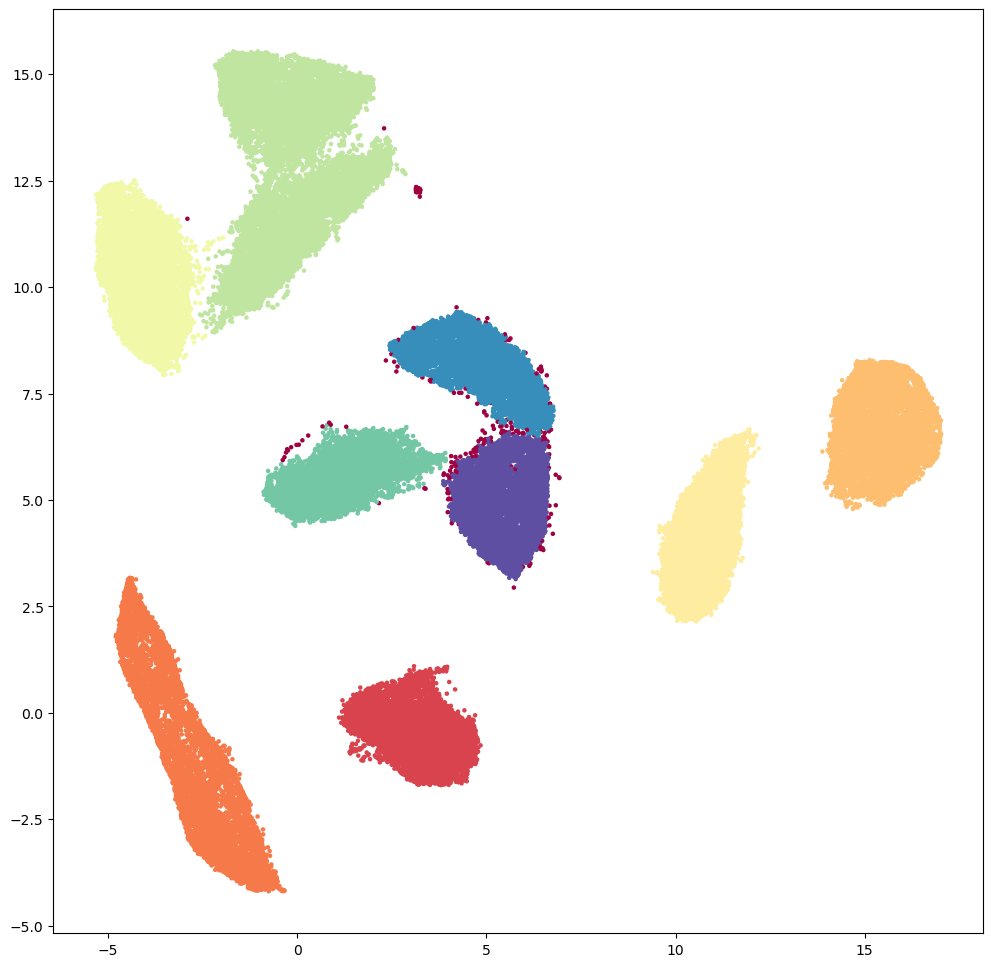

In [46]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*mapper.embedding_.T, s=5, c=hdb_labels, cmap="Spectral", zorder=0)

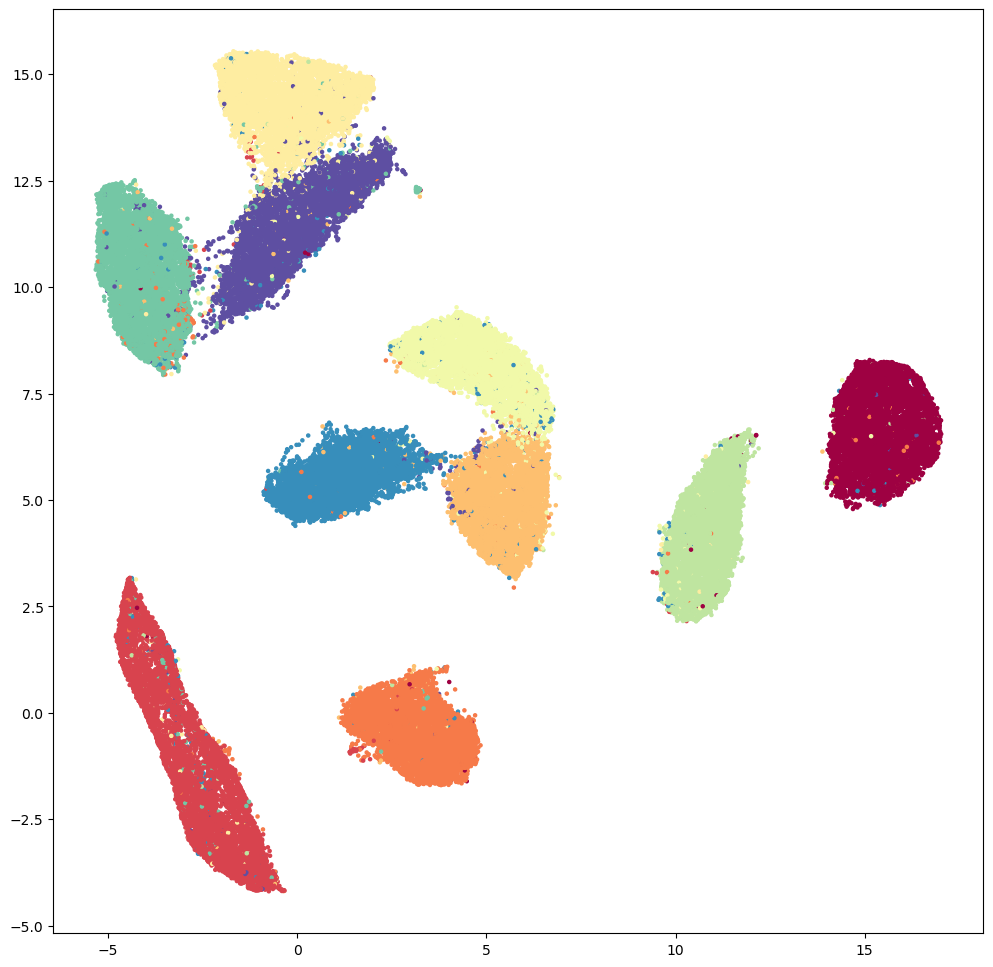

In [47]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(*mapper.embedding_.T, s=5, c=mnist.target.astype(np.int32), cmap="Spectral", zorder=0)